## 3D Terzaghi Layered Consolidation Problem (PINN)

In [19]:
import os
import numpy as np 
import sciann as sn 
import pandas as pd
import matplotlib.pyplot as plt

from sciann.utils.math import sign, abs, sigmoid, tanh, diff

In [20]:
s, minute, hr, day, year = 1., 60., 60.**2, 24*60.**2, 24*60.**2*365.25
mm, cm, m, km = 1e-3, 1e-2, 1.0, 1e3
Pa, kPa, MPa, GPa = 1.0, 1.e3, 1.e6, 1.e9

In [21]:
# ----------------------- Constant Parameters-------------------------
Lx = 1*m
Ly = 1*m
Lz = 1*m

p0 = 1.0*Pa
p_star = 1.0*Pa

x_min, x_max = 0., Lx
y_min, y_max = 0., Ly
z_min, z_max = 0., Lz
t_min, t_max = 0., 1.0

In [30]:
# ----------------------- Neural Network Setup -----------------------
sn.reset_session()
sn.set_random_seed(12345)

xd = sn.Variable('xd', dtype='float32')
yd = sn.Variable('yd', dtype='float32')
zd = sn.Variable('zd', dtype='float32')
td = sn.Variable('td', dtype='float32')

cv1 = sn.Variable('cv1', dtype='float32')
cv2 = sn.Variable('cv2', dtype='float32')
cv3 = sn.Variable('cv3', dtype='float32')

pd = sn.Functional('pd', [xd, yd, zd, td, cv1, cv2, cv3], 6*[40], 'tanh') # change layers?

In [31]:
# Exact solution data
# Define the directory to save the pore pressure data
save_directory = '/rds/general/user/usiddiqu/ephemeral/3D Layered TL'
os.makedirs(save_directory, exist_ok=True)

N = 10

xs = np.linspace(0, 1, N)
ys = np.linspace(0, 1, N)
zs = np.linspace(0, 1, N)
ts = np.linspace(0, 1, 21600)

def load_data(cv1_val, cv2_val, cv3_val, num_data=5000, random=True):
    U_mesh = np.load(os.path.join(save_directory, f'3D_Layered_{cv1_val}_{cv2_val}_{cv3_val}_{N}.npy'))
    print(f'Loaded data for ({cv1_val},{cv2_val},{cv3_val})')
    
    # Flattening the mesh grid
    X, Y, Z, T = np.meshgrid(xs, ys, zs, ts)
    X_flat = X.flatten()[:, None]
    Y_flat = Y.flatten()[:, None]
    Z_flat = Z.flatten()[:, None]
    T_flat = T.flatten()[:, None]
    
    # Calculating U_mesh
    U_mesh_flat = U_mesh.flatten()[:, None]
    
    # Manually select boundary points
    boundary_conditions_idx = np.where((X_flat == 0) | (X_flat == 1) | (Y_flat == 0) | (Y_flat == 1) | (Z_flat == 0) | (Z_flat == 1/3) | (Z_flat == 2/3) | (Z_flat == 1))

    # Combine the boundary indices with the random selection
    boundary_data_count = int(num_data * 0.2)  # For example, select 20% from boundary conditions
    boundary_idx = np.random.choice(boundary_conditions_idx[0], boundary_data_count, replace=False)

    # Randomly select the remaining points
    remaining_data_count = num_data - boundary_data_count
    remaining_idx = np.random.choice(np.setdiff1d(np.arange(Z_flat.shape[0]), boundary_conditions_idx[0]), remaining_data_count, replace=False)

    # Combine the indices and shuffle them
    idx = np.concatenate([boundary_idx, remaining_idx])
    np.random.shuffle(idx)
    
    # Use the selected indices to get the training data
    x_train = X_flat[idx]
    y_train = Y_flat[idx]
    z_train = Z_flat[idx]
    t_train = T_flat[idx]
    u_train = U_mesh_flat[idx]
    
    return x_train, y_train, z_train, t_train, u_train

In [32]:
def get_cv(cv1, cv2, cv3, zd):
    return (cv3 * (2/3 <= zd) * (zd < 1)) + (cv2 * (1/3 <= zd) * (zd < 2/3)) + (cv1 * (0 <= zd) * (zd < 1/3))
    
choices = [
    (0.01, 0.05, 0.10),
    (0.01, 0.10, 0.05),
    (0.05, 0.01, 0.10),
    (0.05, 0.10, 0.01),
    (0.10, 0.01, 0.05),
    (0.10, 0.05, 0.01)
]

x_star, y_star, z_star, t_star, pdata_star, cv1_star, cv2_star, cv3_star = [[] for i in range(8)]

# PDE Equation and BCs
for cv1_val, cv2_val, cv3_val in choices:
    x_data, y_data, z_data, t_data, u_data = load_data(cv1_val, cv2_val, cv3_val)
    
    cv1_star.append(np.ones_like(x_data.reshape(-1, 1)) * cv1_val)
    cv2_star.append(np.ones_linke(x_data.reshape(-1, 1)) * cv2_val)
    cv3_star.append(np.ones_like(x_data.reshape(-1, 1)) * cv3_val)

    x_star.append(x_data.reshape(-1, 1))
    y_star.append(y_data.reshape(-1, 1))
    z_star.append(z_data.reshape(-1, 1))
    t_star.append(t_data.reshape(-1, 1))
    pdata_star.append(u_data.reshape(-1, 1))

x_star = np.concatenate(x_star, axis=0)  
y_star = np.concatenate(y_star, axis=0)  
z_star = np.concatenate(z_star, axis=0)  
t_star = np.concatenate(t_star, axis=0)  
cv1_star = np.concatenate(cv1_star, axis=0)
cv2_star = np.concatenate(cv2_star, axis=0)
cv3_star = np.concatenate(cv3_star, axis=0)
pdata_star = np.concatenate(pdata_star, axis=0)

input_data_3D = [x_star, y_star, z_star, t_star, cv1_star, cv2_star, cv3_star]

targets_vals = [pdata_star] + 10*['zeros']

In [33]:
# ----------- 3D Terzaghi Layered Problem (Physics) -----------------
pd_x, pd_y, pd_z, pd_t = diff(pd, xd), diff(pd, yd), diff(pd, zd), diff(pd, td)
pd_xx = diff(pd_x, xd)
pd_yy = diff(pd_y, yd)
pd_zz = diff(pd_z, zd)

pd_xy = diff(pd_x, yd)
pd_xyz = diff(pd_xy, zd)

# PDE Equation and BCs
PDE_3D = get_cv(cv1,cv2,cv3,zd)*(pd_xx + pd_yy + pd_zz) - pd_t

bc_ini = (td == t_min) * abs(pd - p0/p_star)
bc_left = (xd == x_min) * abs(pd)
bc_right = (xd == x_max) * abs(pd)
bc_front = (yd == y_min) * abs(pd)
bc_back = (yd == y_max) * abs(pd)
bc_bottom = (zd == z_min) * abs(pd_z)
bc_top = (zd == z_max) * abs(pd_z)

# Continuity of pore pressure and flux at layer interfaces
eps = 1e-1000

layer1 = (zd == (2/3 + eps)) *  abs(pd) * cv1 
layer2_1 = (zd == (2/3 - eps)) * abs(pd) * cv2
layer2_2 = (zd == (1/3 + eps)) * abs(pd) * cv2
layer3 = (zd == (1/3 - eps)) * abs(pd) * cv3

p12 = (zd == 2/3) * abs(pd)
p23 = (zd == 1/3) * abs(pd)

interface_1_2 = (layer1 + layer2_1) - p12*(cv1+cv2)
interface_2_3 = (layer2_2 + layer3) - p23*(cv2+cv3)

targets_3D = [sn.Data(pd), sn.PDE(PDE_3D), bc_ini, bc_left, bc_right, bc_front, bc_back, bc_bottom, bc_top, interface_1_2, interface_2_3]

In [34]:
epochs = 10
batch_size = 5000

initial_lr = 1e-3
final_lr = initial_lr/100

learning_rate = {
    "scheduler": "ExponentialDecay", 
    "initial_learning_rate": initial_lr,
    "final_learning_rate": final_lr, 
    "decay_epochs": epochs
}

In [35]:
train = False
load_weights = not train

# Create and train the model
model = sn.SciModel(
    [xd, yd, zd, td, cv1, cv2, cv3],
    targets_3D,
    "mse",
    "Adam",
    load_weights_from = 'Terzaghi_3D_TL_Layered_200000.hdf5' if load_weights else None 
)

if train:
    global H
    H = model.train(
        input_data_3D,
        targets_vals,
        epochs=epochs,
        batch_size=batch_size,
        learning_rate=learning_rate,
        stop_loss_value=1e-8,
        stop_after=None,
        verbose=2
    )

    model.save_weights('Terzaghi_TL_Layered_test.hdf5')

In [36]:
if train:
    loss = H.history["loss"]
    learning_rate = H.history["lr"]

    def cust_semilogx(AX, X, Y, xlabel, ylabel, title):
        if X is None:
            im = AX.semilogy(Y)
        else:
            im = AX.semilogy(X, Y)
        if xlabel is not None: AX.set_xlabel(xlabel)
        if ylabel is not None: AX.set_ylabel(ylabel)
        if title is not None: AX.set_title(title)

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    cust_semilogx(ax[0], None, np.array(loss) / loss[0], "epochs", "L/L0", "Loss")
    cust_semilogx(ax[1], None, np.array(learning_rate), "epochs", "lr", "Learning Rate")

    fig.subplots_adjust(left=0.1, right=0.9, bottom=0.15, top=0.9, wspace=0.3, hspace=0.2)
    plt.savefig('Epochs_3D.png',dpi=600)
    plt.show()

### Inversion

In [37]:
# ---------------- Loading Data -----------------

cv1_test, cv2_test, cv3_test = 0.05, 0.10, 0.01
N = 60

u_loaded = np.load(os.path.join(save_directory, f'3D_Layered_{cv1_test}_{cv2_test}_{cv3_test}_{N}.npy'))

t_index = int(0.3 * (21600-1)) # using t = 0.3 to test.
u_t = u_loaded[:, :, :, t_index]

xs = np.linspace(0, 1, N)
ys = np.linspace(0, 1, N)
zs = np.linspace(0, 1, N)
ts = np.linspace(0, 1, 21600)
Xtest, Ytest, Ztest = np.meshgrid(xs, ys, zs, indexing='ij')

# Lists to store cv1, cv2, cv3 values during optimization (for plotting)
cv1_tested = []
cv2_tested = []
cv3_tested = []

Optimized cv1 = 0.048567, cv2 = 0.103988, cv3 = 0.008002


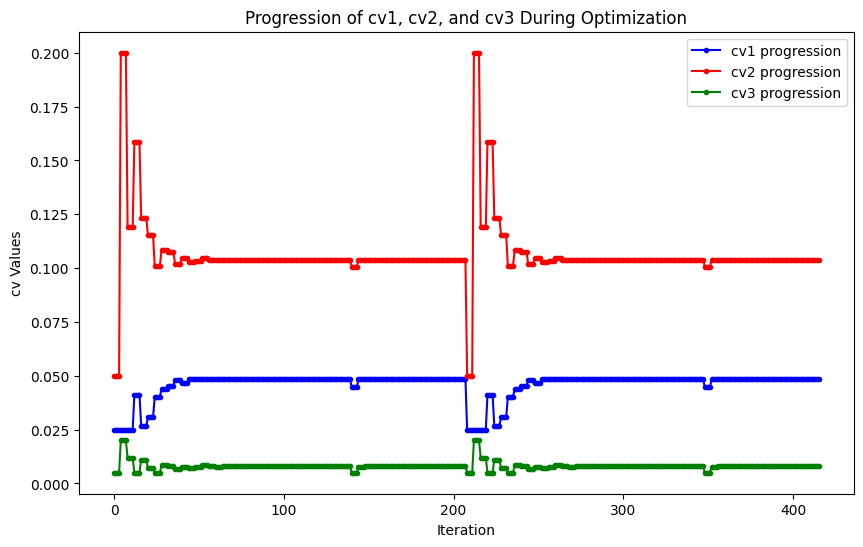

In [19]:
from scipy.optimize import minimize

def error_function(cv_values):
    cv1_val, cv2_val, cv3_val = cv_values
    
    # Log the current cv values for plotting
    cv1_tested.append(cv1_val)
    cv2_tested.append(cv2_val)
    cv3_tested.append(cv3_val)
    
    cv1_arr = np.ones_like(Xtest.flatten()) * cv1_val
    cv2_arr = np.ones_like(Xtest.flatten()) * cv2_val
    cv3_arr = np.ones_like(Xtest.flatten()) * cv3_val

    # Create input for the model and evaluate pd
    input_test = [Xtest.flatten(), Ytest.flatten(), Ztest.flatten(), np.full_like(Xtest.flatten(), ts[t_index]), cv1_arr, cv2_arr, cv3_arr]
    pd_eval = pd.eval(input_test).reshape(Xtest.shape)
    
    # Calculate the error between pd_eval and exact solution u_t
    return np.mean((pd_eval - u_t)**2)

# Initial guess for [cv1, cv2, cv3]
initial_guess = [0., 0., 0.]

# Bounds for each cv value
bounds = [(cv1_test/2, cv1_test*2), (cv2_test/2, cv2_test*2), (cv3_test/2, cv3_test*2)]

# Perform optimization
result = minimize(error_function, initial_guess, bounds=bounds)
best_cv1, best_cv2, best_cv3 = result.x

# Print optimized values
print(f"Optimized cv1 = {best_cv1:.6f}, cv2 = {best_cv2:.6f}, cv3 = {best_cv3:.6f}")

# Plot the values of cv1, cv2, and cv3 over iterations
plt.figure(figsize=(10, 6))
plt.plot(cv1_tested, label='cv1 progression', marker='.', color='b')
plt.plot(cv2_tested, label='cv2 progression', marker='.', color='r')
plt.plot(cv3_tested, label='cv3 progression', marker='.', color='g')
plt.xlabel("Iteration")
plt.ylabel("cv Values")
plt.title("Progression of cv1, cv2, and cv3 During Optimization")
plt.legend()
plt.show()

### PINN and Exact Solution

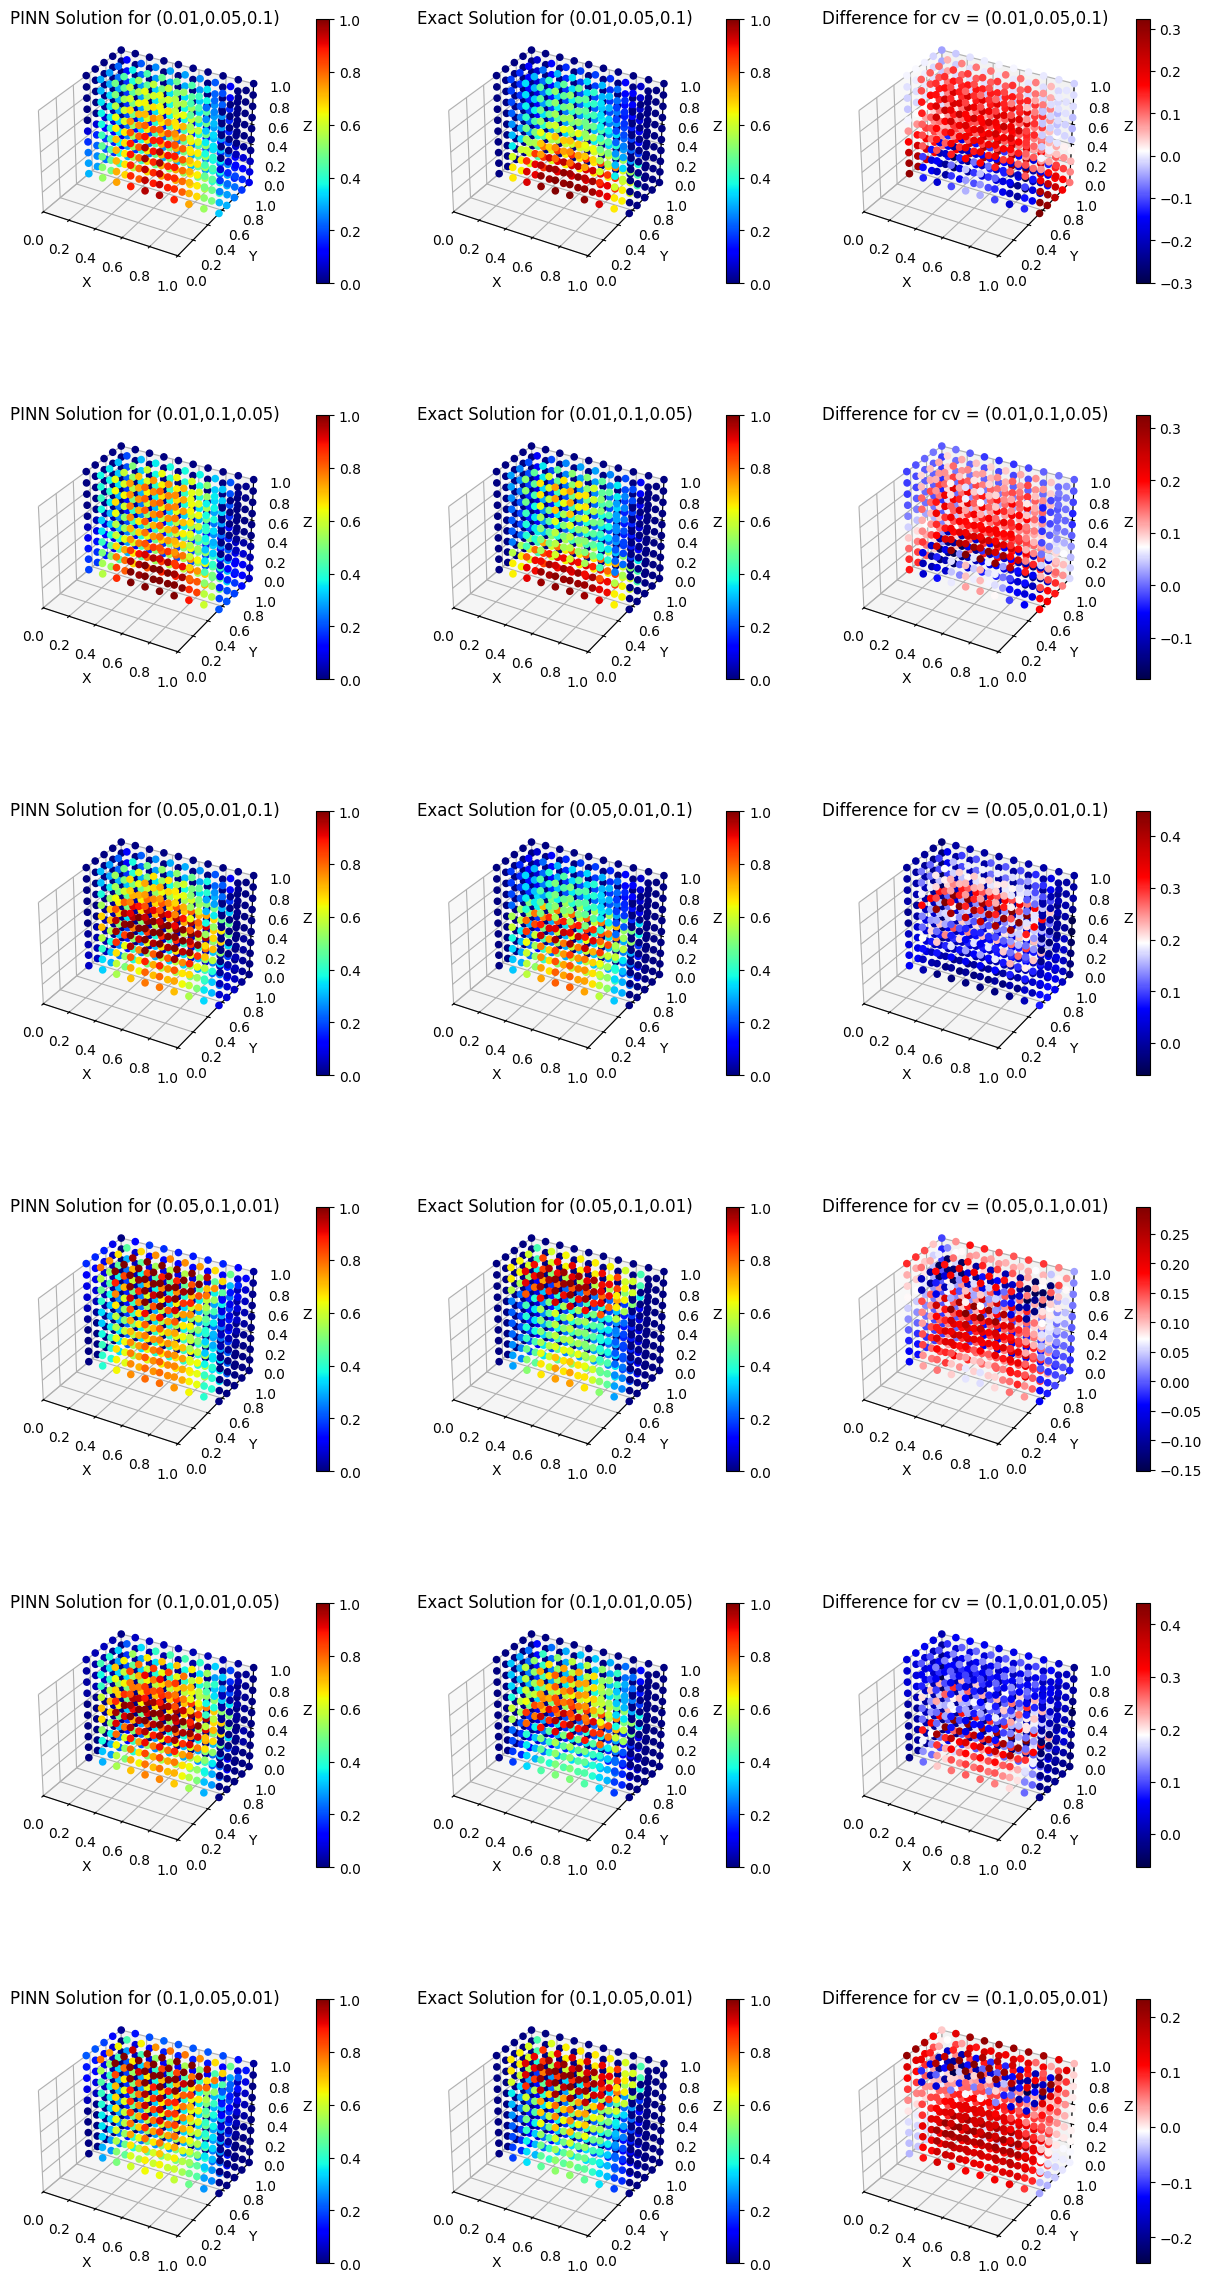

In [39]:
choices_test = [
    (0.01, 0.05, 0.10),
    (0.01, 0.10, 0.05),
    (0.05, 0.01, 0.10),
    (0.05, 0.10, 0.01),
    (0.10, 0.01, 0.05),
    (0.10, 0.05, 0.01)
]

N = 10

# Define the evaluation grid
xs = np.linspace(0, 1, N)
ys = np.linspace(0, 1, N)
zs = np.linspace(0, 1, N)
ts = np.linspace(0, 1, 21600)

# Loop through different time points to plot 3D contours
fig, axs = plt.subplots(6, 3, figsize=(15, 30), subplot_kw={'projection': '3d'})

for i, (cv1_val, cv2_val, cv3_val) in enumerate(choices_test):
    u_loaded = np.load(os.path.join(save_directory, f'3D_Layered_{cv1_val}_{cv2_val}_{cv3_val}_{N}.npy'))
    
    # Meshgrid for 3D evaluation
    Xtest, Ytest, Ztest = np.meshgrid(xs, ys, zs, indexing='ij')
    cv1_arr = np.ones_like(Xtest.flatten()) * cv1_val
    cv2_arr = np.ones_like(Xtest.flatten()) * cv2_val
    cv3_arr = np.ones_like(Xtest.flatten()) * cv3_val

    t_index = int(0.5 * (21600-1)) # using t = 0.5 to plot.
    
    input_test = [Xtest.flatten(), Ytest.flatten(), Ztest.flatten(), np.full_like(Xtest.flatten(), ts[t_index]), cv1_arr, cv2_arr, cv3_arr]
    
    # Evaluate model predictions at the specific time point
    p_pred_fixed_time = pd.eval(input_test).reshape(Xtest.shape)

    # Extract the exact pore pressure at the specified time
    u_t = u_loaded[:, :, :, t_index]
    
    # Calculate the difference/errors
    difference = p_pred_fixed_time - u_t
    
    # Flatten data for 3D plotting
    x_flat = Xtest.flatten()
    y_flat = Ytest.flatten()
    z_flat = Ztest.flatten()
    p_flat = p_pred_fixed_time.flatten()
    
    u_flat = u_t.flatten()
    d_flat = difference.flatten()

    # Filter to include only the specified y range
    mask = (y_flat >= 0.5) & (y_flat <= 1.0)

    # Plotting PINN result
    scatter_plot_0 = axs[i, 0].scatter(x_flat[mask], y_flat[mask], z_flat[mask], c=p_flat[mask], cmap='jet', marker='o', alpha=1., vmin=0, vmax=1)
    axs[i, 0].set_title(f'PINN Solution for ({cv1_val},{cv2_val},{cv3_val})')
    axs[i, 0].set_xlabel('X')
    axs[i, 0].set_ylabel('Y')
    axs[i, 0].set_zlabel('Z')
    axs[i, 0].set_xlim([0, 1])
    axs[i, 0].set_ylim([0, 1])
    axs[i, 0].set_zlim([0, 1])
    fig.colorbar(scatter_plot_0, ax=axs[i, 0], shrink=0.8, pad=0.15)

    # Plotting exact solution
    scatter_plot_1 = axs[i, 1].scatter(x_flat[mask], y_flat[mask], z_flat[mask], c=u_flat[mask], cmap='jet', marker='o', alpha=1., vmin=0, vmax=1)
    axs[i, 1].set_title(f'Exact Solution for ({cv1_val},{cv2_val},{cv3_val})')
    axs[i, 1].set_xlabel('X')
    axs[i, 1].set_ylabel('Y')
    axs[i, 1].set_zlabel('Z')
    axs[i, 1].set_xlim([0, 1])
    axs[i, 1].set_ylim([0, 1])
    axs[i, 1].set_zlim([0, 1])
    fig.colorbar(scatter_plot_1, ax=axs[i, 1], shrink=0.8, pad=0.15)
    
    # Plotting difference/errors
    scatter_plot_2 = axs[i, 2].scatter(x_flat[mask], y_flat[mask], z_flat[mask], c=d_flat[mask], cmap='seismic', marker='o', alpha=1.)
    axs[i, 2].set_title(f'Difference for cv = ({cv1_val},{cv2_val},{cv3_val})')
    axs[i, 2].set_xlabel('X')
    axs[i, 2].set_ylabel('Y')
    axs[i, 2].set_zlabel('Z')
    axs[i, 2].set_xlim([0, 1])
    axs[i, 2].set_ylim([0, 1])
    axs[i, 2].set_zlim([0, 1])
    fig.colorbar(scatter_plot_2, ax=axs[i, 2], shrink=0.8, pad=0.15)

plt.savefig(f"3D-Contour-Plots_Layered.png", dpi=600)
plt.show()

In [ ]:
# from matplotlib.lines import Line2D

# Xtest, Ytest, Ztest = np.meshgrid(xs, ys, zs, indexing='ij')

# # Plot pore pressure for different time points
# fig, ax = plt.subplots(figsize=(10, 6))

# time_points = [0.8, 0.4, 0.2]
# for idx, time_point in enumerate(time_points):
#     t_index = int(time_point * (Nt-1))
#     u_t = u_loaded[:, Ny//2, Nz//2, t_index]  # Extracting along the x direction at the middle of y and z

#     # PINN Result
#     input_test = [Xtest.flatten(), Ytest.flatten(), Ztest.flatten(), np.full(Xtest.flatten().shape, ts[t_index])]
#     p_pred_fixed_time = pd.eval(input_test).reshape(Xtest.shape)
#     p_pred_x = p_pred_fixed_time[:, Ny//2, Nz//2]
    
#     max_u_t = np.argmax(u_t)
    
#     ax.plot(xs, u_t, color='red', label='Exact')
#     ax.plot(xs, p_pred_x, '--', color='blue', label='PINN')

#     # Annotate the lines with their respective time points
#     ax.annotate(f't = {time_point}', xy=(xs[max_u_t], u_t[max_u_t]), xytext=(-10, 5), textcoords='offset points')

# # Custom legend
# legend_elements = [Line2D([0], [0], color='red', label='Exact'),
#                    Line2D([0], [0], color='blue', linestyle='--', label='PINN')]

# ax.legend(handles=legend_elements, loc='best')

# ax.set_xlabel('X/Y')
# ax.set_ylabel('Pore Pressure')
# ax.grid(True)
# plt.title('PINN and Exact Solution')
# plt.savefig("Pore_Pressure_vs_XY.png", dpi=600, transparent=True)
# plt.show()

In [ ]:
# # Plot pore pressure for different time points
# fig, ax = plt.subplots(figsize=(10, 6))

# for time_point in [0.2, 0.4, 0.8]:
#     t_index = int(time_point * (Nt-1))
#     u_t = u_loaded[Nx//2, Ny//2, :, t_index]  # Extracting along the z direction at the middle of x and y

#     # PINN Result
#     input_test = [Xtest.flatten(), Ytest.flatten(), Ztest.flatten(), np.full(Xtest.flatten().shape, ts[t_index])]
#     p_pred_fixed_time = pd.eval(input_test).reshape(Xtest.shape)
#     p_pred_z = p_pred_fixed_time[Nx//2, Ny//2, :]

#     ax.plot(zs, u_t, color='red', label=f'Exact t = {time_point}')
#     ax.plot(zs, p_pred_z, '--', color='blue', label=f'PINN t = {time_point}')

#     # Annotate the lines with their respective time points
#     ax.annotate(f't = {time_point}', xy=(zs[-1], p_pred_z[-1]), xytext=(-40, -20), textcoords='offset points')

# # Custom legend
# legend_elements = [Line2D([0], [0], color='red', label='Exact'),
#                    Line2D([0], [0], color='blue', linestyle='--', label='PINN')]

# ax.legend(handles=legend_elements, loc='best')
    
# ax.set_xlabel('Z')
# ax.set_ylabel('Pore Pressure')
# ax.grid(True)
# #ax.set_ylim(0, 1)

# plt.title('PINN and Exact Solution')
# plt.savefig("Pore_Pressure_vs_Z.png", dpi=600, transparent=True)
# plt.show()